In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
#  import matplotlib.pyplot as plt
import pylab
import os
import pydicom
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
from skimage import measure
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from PIL import Image
from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Input,\
UpSampling2D, LeakyReLU, Conv2D, MaxPool2D
# , AvgPool2D, Lambda, LocallyConnected2D, Conv2D, multiply, Flatten
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau\
    # , LearningRateScheduler
from keras.losses import binary_crossentropy
from keras.utils import Sequence
from keras import layers
import keras_preprocessing.image as KPImage

BASE_MODEL = 'DenseNet121' # ['InceptionV3', 'Xception', 'DenseNet169', 'VGG16']
BASE_IMG_SIZE = 1024
IMG_SPLITS = BASE_IMG_SIZE // 224  # 4
PT_IMG_SIZE = (256, 256, 3)
IMG_SIZE =  (PT_IMG_SIZE[0] * IMG_SPLITS, PT_IMG_SIZE[1] * IMG_SPLITS)
BATCH_SIZE = 16
DENSE_COUNT = 128
DROPOUT = 0.25
LEARN_RATE = 1e-4
TRAIN_SAMPLES = 8000
TEST_SAMPLES = 800
USE_ATTN = False

Using TensorFlow backend.


In [2]:
# Initialize paths to image directories
det_class_path = '../input/stage_1_detailed_class_info.csv'
bbox_path = '../input/stage_1_train_labels.csv'
dicom_dir = '../input/stage_1_train_images/'

# Labels contains the target (1=pneumonia, 0=healthy) and bounding boxes
# if that patient has pneumonia
bbox_df = pd.read_csv(bbox_path)

# Create new column grouping together bounding box parameters into list
bbox_df[['x', 'y', 'width', 'height']] = \
    bbox_df[['x', 'y', 'width', 'height']].fillna(0.0).astype('int')

# Create new dataframe with a column bbox which contains the info about 
# the bounding box
comb_bbox_df = bbox_df
comb_bbox_df['bbox'] = bbox_df[['x', 'y', 'width', 'height']].values.tolist()

del(bbox_df)

# Now group together multiple bounding boxes for each patient into another list
# If the patient is healthy then this list will contain [0,0,0,0] indicating no bboxs
grouped_bbox_df = comb_bbox_df.groupby('patientId')['bbox'].apply(list)
grouped_bbox_df.head(10)

del(comb_bbox_df)

In [3]:
# This takes a while and only needs to be ran once to generate all the necessary images

#for pid, boxes in grouped_bbox_df.items():
#    if os.path.isfile(os.path.join(dicom_dir, "src/" + str(pid) + ".png")):
#        continue
    #if os.path.isfile(os.path.join(dicom_dir, "masks/msk/" + str(pid) + "-mask.png")):
    #    continue
    # load dicom file as numpy array

#    img = pydicom.dcmread(os.path.join(dicom_dir, str(pid) + ".dcm")).pixel_array
    # create empty mask
#    msk = np.zeros(img.shape, dtype=np.uint8)
    
#    if boxes[0] != [0,0,0,0]:
        # loop through bounding boxes
#        for box in boxes:
            # add 1's at the locations indicating pneumonia
#            x, y, w, h = box
#            msk[y:y + h, x:x + w] = 255
            
    
#    msk2 = np.repeat(msk[:,:,np.newaxis], 3, axis=2)
    
#    msk3 = Image.fromarray(msk2, 'RGB')
#    msk3.save(os.path.join(dicom_dir, "full_masks/msk/" + str(pid) + "-mask.png"))
    
    # resize image and scale up to 8bit colorspace, dont need to multiply by 255
#    img2 = np.repeat(img[:,:,np.newaxis], 3, axis=2)
#    img3 = Image.fromarray(img2, 'RGB')
#    img3.save(os.path.join(dicom_dir, "full_sources/src/" + str(pid) + ".png"))

In [4]:
# we create two instances with the same arguments and a 10% validation split
data_gen_args = {'validation_split': 0.1}
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 2018

image_dir = dicom_dir + 'full_sources'
target_dir = dicom_dir + 'full_masks'

train_image_generator = image_datagen.flow_from_directory(
    image_dir,
    class_mode=None,
    seed=seed,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training')
train_mask_generator = mask_datagen.flow_from_directory(
    target_dir,
    class_mode=None,
    seed=seed,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training')
valid_image_generator = image_datagen.flow_from_directory(
    image_dir,
    class_mode=None,
    seed=seed,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation')
valid_mask_generator = mask_datagen.flow_from_directory(
    target_dir,
    class_mode=None,
    seed=seed,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation')

# combine generators into one which yields image and masks
train_generator = zip(train_image_generator, train_mask_generator)
valid_generator = zip(valid_image_generator, valid_mask_generator)

Found 6338 images belonging to 1 classes.
Found 6338 images belonging to 1 classes.
Found 704 images belonging to 1 classes.
Found 704 images belonging to 1 classes.


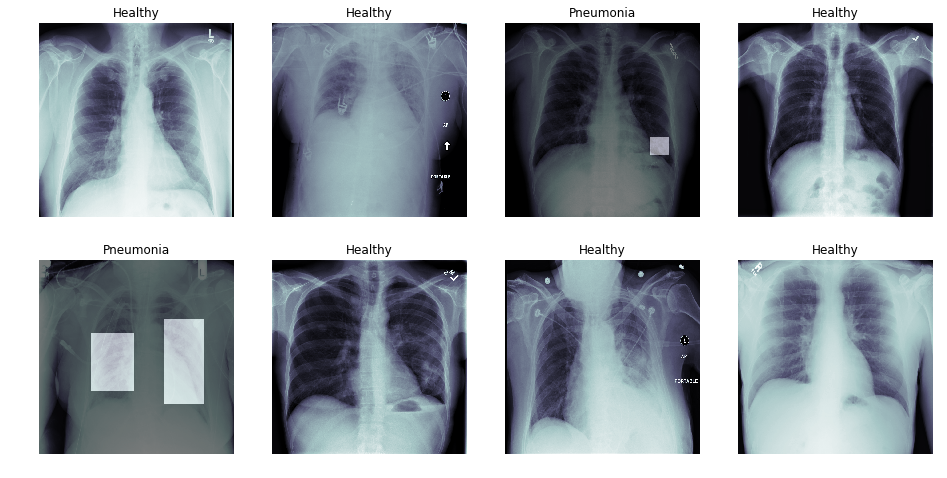

In [5]:
train_src, train_tar = next(train_generator)
#valid_src, valid_tar = next(valid_generator)

#print(train_src.shape, train_tar.shape)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (t_src, t_tar, ax) in zip(train_src, train_tar, m_axs.flatten()):
    ax.imshow(t_src[:,:,0], cmap = 'bone')
    if np.all(t_tar<1):
        # If the mask is all 0 then there's no pneumonia
        title = 'Healthy'
    else:
        title = 'Pneumonia'
        ax.imshow(t_tar[:,:,:]/255, alpha=0.5)
    ax.set_title('%s' % title)
    ax.axis('off')

del(train_src)
del(train_tar)

In [6]:
base_pretrained_model = PTModel(input_shape = PT_IMG_SIZE, # train_src.shape[1:], 
                                include_top = False)
base_pretrained_model.trainable = False
base_pretrained_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [7]:
def get_feats(img, msk, model):
    X = []
    y = []
    
    pred = model.predict(img, batch_size = 1)
    feat_width, feat_height, depth = pred[0].shape
    
    msk_small = resize(msk, 
                       (1, model.output_shape[1], model.output_shape[2], 1),
                       mode='reflect',
                       anti_aliasing=False)
    msk_small[msk_small > 0] = 1
    [y.append(val) for val in msk_small.flatten()]
    for i in range(feat_width):
        for j in range(feat_height):
            X.append(pred[0][i][j])
    return (X, y)

def gen_data(gen, model, return_images=False, exclude_neg=True):
    X = []
    y = []
    src_out = []
    tar_out = []
    src, tar = next(gen)
    # preds = model.predict(src, batch_size = BATCH_SIZE)
    # 

    for src_img, tar_msk in zip(src, tar):
        if not tar_msk.any() and exclude_neg:
            # This will get only cases with boxes to provide more positive cases
            continue
        if return_images:
            src_out.append(src_img)
            tar_out.append(tar_msk)
            
        for x_split in range(IMG_SPLITS):
            for y_split in range(IMG_SPLITS):
                src_chunk = np.array([src_img\
                            [x_split * PT_IMG_SIZE[0]:x_split * PT_IMG_SIZE[0] + PT_IMG_SIZE[0]\
                            , y_split * PT_IMG_SIZE[0]:y_split * PT_IMG_SIZE[0] + PT_IMG_SIZE[0]\
                            , :]])
                tar_chunk = np.array([tar_msk\
                            [x_split * PT_IMG_SIZE[0]:x_split * PT_IMG_SIZE[0] + PT_IMG_SIZE[0]\
                            , y_split * PT_IMG_SIZE[0]:y_split * PT_IMG_SIZE[0] + PT_IMG_SIZE[0]\
                            , :]])
                
                X_out, y_out = get_feats(src_chunk, tar_chunk, model)
                [X.append(val) for val in X_out]
                [y.append(val) for val in y_out]
        
    if return_images:
        return (X, y, src_out, tar_out)
    else:
        return (X, y)

In [12]:
# Define metrics here

def draw_predicted_boxes(classifier, show=False):
    images_wide = 4
    images_high = 4
    total_images = images_wide * images_high

    if(show):
        f, axarr = plt.subplots(images_wide, images_high, figsize=(20,15))
        axarr = axarr.ravel()
    axidx = 0
    
    iou = []

    while(axidx < total_images):
        """
        msk_7x7 = resize(tar_msk,
                         (7, 7, 3),
                         mode='constant',
                         anti_aliasing=False)
        msk_7x7 = resize(msk_7x7,
                         (224, 224, 3),
                         mode='constant',
                         anti_aliasing=False) """

        # msk_7x7[msk_7x7 > 0] = 1
        # pred_ax.imshow(msk_7x7[:,:,:], alpha=0.5)

        X_test, y_test, test_img, test_msk = gen_data(valid_generator,
                                                      base_pretrained_model,
                                                      return_images=True,
                                                      exclude_neg=False)
        # print(len(X_test))
        for img_no in range(BATCH_SIZE):
            if axidx >= total_images:
                break
            mask = test_msk[img_no][:,:,0]
            mask[mask>0] = 1
            

            comp = np.empty([base_pretrained_model.output_shape[1] * IMG_SPLITS,
                             base_pretrained_model.output_shape[2] * IMG_SPLITS
                             ])
            for x_split in range(IMG_SPLITS):
                for y_split in range(IMG_SPLITS):
                    for i in range(base_pretrained_model.output_shape[1]):
                        for j in range(base_pretrained_model.output_shape[2]):
                            # Height and width offset by image number
                            current_feat = img_no * (base_pretrained_model.output_shape[1] * IMG_SPLITS) ** 2 +\
                                i * base_pretrained_model.output_shape[1] + j + \
                                y_split * (base_pretrained_model.output_shape[1] ** 2) + \
                                x_split * IMG_SPLITS * (base_pretrained_model.output_shape[1] ** 2)

                            comp[(x_split * base_pretrained_model.output_shape[1]) + i \
                                , (y_split * base_pretrained_model.output_shape[2]) + j] \
                                = classifier.predict([X_test[current_feat]])[0]

            comp = resize(comp,
                          (IMG_SIZE[0], IMG_SIZE[1], 1),
                          mode='constant',
                          anti_aliasing=False
                          )
            comp[comp>0] = 1
            comp = comp[:,:,0]
            
            # Calculate IOU
            intersect = np.multiply(mask, comp[:,:,0]).sum()
            union = mask.sum() + comp.sum() - intersect
            iou.append(intersect / union)
            
            if(show):
                axarr[axidx].imshow(test_img[img_no][:,:,0], cmap = 'bone')
                axarr[axidx].imshow(mask, alpha=0.5, cmap = 'pink')
                axarr[axidx].imshow(comp, alpha=0.2, cmap = 'bone')
                # apply connected components
                comp = measure.label(comp)
                # apply bounding boxes
                predictionString = ''
                for region in measure.regionprops(comp):
                    # retrieve x, y, height and width
                    y, x, y2, x2 = region.bbox
                    height = y2 - y
                    width = x2 - x
                    if height * width < 10000:
                        continue
                    axarr[axidx].add_patch(patches.Rectangle((x,y),
                                                             width,
                                                             height,
                                                             linewidth=2,
                                                             edgecolor='r',
                                                             facecolor='none'))
            axidx += 1
        if show:
            plt.show()
    return iou

def find_accuracy(classifier):
    X_valid = []
    y_valid = []

    all_p = []
    output = []
    tp = []
    all_y = []
    for _ in range(4):
        X_valid, y_valid = gen_data(valid_generator, base_pretrained_model)
        [all_y.append(val) for val in y_valid]
        for i in range(len(X_valid)):
            prediction = classifier.predict([X_valid[i]])[0]
            all_p.append(prediction)  # All true values
            output.append(prediction == y_valid[i])  # All correct, pos and neg
            tp.append(prediction * y_valid[i])  # True positive, where it says 1 and it is

    #print(len(output))
    print("Precision: " + str(sum(output)/len(output)))  # Precision
    #print((sum(all_p), sum(all_y)))
    print("Recall: " + str(sum(tp)/sum(all_y)))  # Recall more important because most vectors will be 0
    return(sum(output)/len(output), sum(tp)/sum(all_y))

In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.externals import joblib
from time import time

precisions = []
recalls = []
times = []
ious = []

X_train = []
y_train = []
X_test = []
y_test = []
h = .02  # step size in the mesh

names = ["Naive Bayes",
         "Nearest Neighbors",
         "Linear SVM",
         "RBF SVM",
         # "Gaussian Process",
         "Decision Tree",
         "Random Forest",
         "Neural Net",
         "AdaBoost"         
         #"QDA"
         ]

classifiers = [
    GaussianNB(),
    KNeighborsClassifier(),
    SVC(kernel="linear", C=0.01),
    SVC(kernel="rbf", gamma="scale", C=10),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(min_samples_leaf=3),
    RandomForestClassifier(n_estimators=10, min_samples_leaf=3),
    MLPClassifier(alpha=1),
    AdaBoostClassifier()
    #QuadraticDiscriminantAnalysis()
    ]

for _ in range(5):  # range(len(grouped_bbox_df)/BATCH_SIZE):
    X, y = gen_data(train_generator, base_pretrained_model)
    [X_train.append(val) for val in X]
    [y_train.append(val) for val in y]
    # X, y = gen_data(valid_generator, base_pretrained_model)
    # [X_test.append(val) for val in X]
    # [y_test.append(val) for val in y]
   
# Train
print("Starting Training")

# iterate over classifiers
for name, clf in zip(names, classifiers):
    print(name)
    start_time = time()
    clf.fit(X_train, y_train)
    times.append(time() - start_time)
    #score = clf.score(X_test, y_test)
    precision, recall = find_accuracy(clf)
    precisions.append(precision)
    recalls.append(recall)
    iou = draw_predicted_boxes(clf)
    ious.append(sum(iou)/len(iou))
        

#joblib.dump(rf_clf, 'densenet_svm_split.joblib') 

#print(find_accuracy(rf_clf))
#print(draw_predicted_boxes(rf_clf))

Starting Training
Naive Bayes
Precision: 0.5035342261904762
Recall: 0.8614855176369371
Nearest Neighbors
Precision: 0.8190696022727273
Recall: 0.22140430351075877
Linear SVM
Precision: 0.8175455729166666
Recall: 0.1642978965321205
RBF SVM
Precision: 0.8024088541666666
Recall: 0.23780794369029662
Decision Tree
Precision: 0.7875689338235294
Recall: 0.2774952320406866
Random Forest
Precision: 0.79833984375
Recall: 0.061584454409566516
Neural Net
Precision: 0.8426688058035714
Recall: 0.20531577663984393
AdaBoost
Precision: 0.7938910590277778
Recall: 0.0916030534351145


(50, 86, 8)
(81, 22, 3)
(81, 16, 7)
(80, 23, 13)
(78, 27, 5)
(79, 6, 1)
(84, 20, 5)
(79, 9, 6)


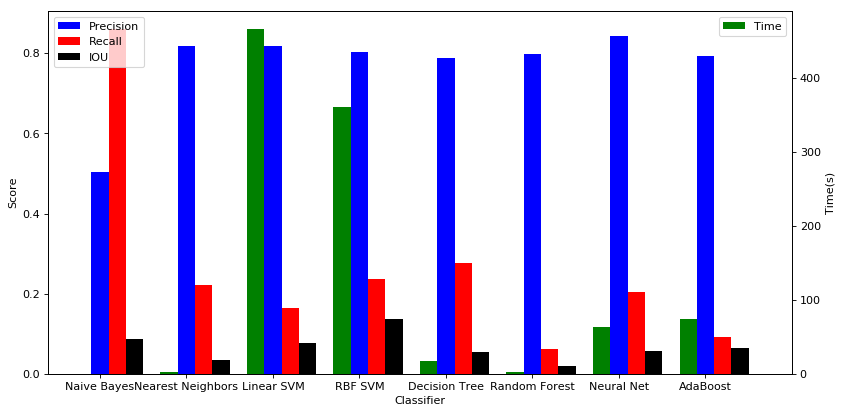

In [26]:
indent = np.arange(len(names))        
fig = plt.figure(figsize=(12, 6), dpi=80)
ax = fig.add_subplot(111)
ax2 = ax.twinx()
width = 0.2
ax.bar(indent, precisions, width, color='b', align='center', label='Precision')
ax.bar(indent+width, recalls, width, color='r', align='center', label='Recall')
ax.bar(indent+ 2 * width, ious, width, color='k', align='center', label='IOU')
ax2.bar(indent-width, times, width, color='g', align='center', label='Time')

ax.set(xticks=indent, xticklabels=names, xlim=[2*width - 1, len(names)])
ax.legend(loc=2)
ax2.legend(loc=0)
ax.set_ylabel('Score')
ax.set_xlabel('Classifier')
ax2.set_ylabel('Time(s)')
plt.draw()
plt.savefig('classifier_comparison.png')
out = [print((int(p*100), int(r*100), int(i*100))) for p, r, i in
          zip(precisions, recalls, ious)]

In [ ]:
from sklearn import svm

svm_clf = svm.SVC(C=10, gamma='scale')
X_train = []
y_train = []

for _ in range(5):  # range(len(grouped_bbox_df)/BATCH_SIZE):
    X, y = gen_data(train_generator, base_pretrained_model)
    [X_train.append(val) for val in X]
    [y_train.append(val) for val in y]
                
#print("Starting Training")
print(svm_clf.fit(X_train, y_train))
#joblib.dump(svm_clf, 'densenet_svm_split.joblib') 

print("Number of training vectors: " + str(len(X_train)))
print("Number of support vectors: " + str(clf.n_support_))

print(find_accuracy(svm_clf))
print(draw_predicted_boxes(svm_clf, show=True))
# C = 100000: 0.379281537176274 / 20 train batch: 0.4097771387491014
# C = 10000 : 0.37610264635124296
# C = 1000  : 0.350354609929078
# C = 100   : 0.38436692506459946
# C = 10    : 0.32

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.title("IOU Loss")
#plt.subplot(132)
#plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
#plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
#plt.legend()
plt.subplot(122)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.title("Mean IOU")
plt.show()